In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [3]:
import yaml
from dataset.labeled_dataset import EEGLabeledDataset, collate_fn
from models.bendr import EncoderConv, ContextNetwork, calc_loss_proper
from utils.training_utils import emb_std, emb_mean, best_ce_loss, warn_one_batch, info_about_training
from utils.data_utils import plot_spec, plot_first_n, calc_part_clipped

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import SequentialLR, LinearLR
import torch
import yaml
import numpy as np


# fix random seeds for reproducibility
SEED = 456
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

device = torch.device('mps')

with open('configs/clean_config_bendr.yaml', 'r') as file:
        cfg = yaml.safe_load(file)

dataset = EEGLabeledDataset(**cfg['data'])
loader = DataLoader(dataset, cfg['data']['batch_size'], num_workers=cfg['data']['num_workers'], 
                    persistent_workers=cfg['data']['persistent_workers'],
                    shuffle=False, drop_last=True, collate_fn=collate_fn)

encoder_sd = torch.load('/Users/ksc/Desktop/Нейротемка/code_local/neural_foundation/src/checkpoints/encoder_2024-09-23T15:01:45.290351.pt')
context_network_sd = torch.load('/Users/ksc/Desktop/Нейротемка/code_local/neural_foundation/src/checkpoints/context_network_2024-09-23T15:01:45.335782.pt')


encoder = EncoderConv(**cfg['encoder'])
context_network = ContextNetwork(**cfg['context_network'])

encoder.load_state_dict(encoder_sd)
context_network.load_state_dict(context_network_sd)

encoder = encoder.to(device)
context_network = context_network.to(device)

/var/folders/z2/jk8j2nn905v4_76cbzdgkrxm0000gn/T/ipykernel_36264/1474057749.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_sd = torch.load('/Users/ksc/Desktop/

In [4]:
from models.bendr import pick_negatives, calc_loss_proper

res = []
with torch.no_grad():
    for batch_idx, batch in enumerate(loader):
        batch['data'] = batch['data'].to(device, dtype=torch.float32)
        
        batch = encoder(batch)
        batch = context_network(batch)
        batch = calc_loss_proper(batch, cfg['context_network']['temp'],  cfg['context_network']['num_negatives'])
        res.append(batch)

/Users/ksc/Desktop/Нейротемка/code_local/neural_foundation/src/dataset/labeled_dataset.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  proc_data = torch.load(self.cach

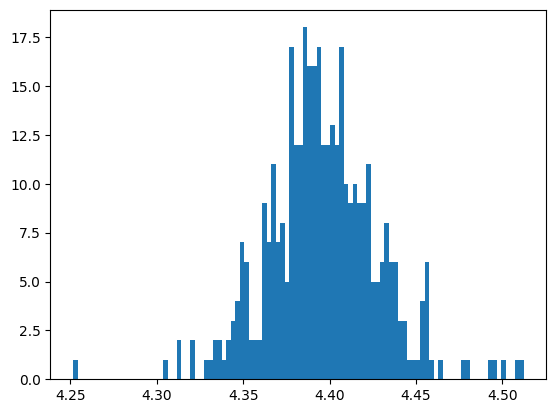

In [8]:
import matplotlib.pyplot as plt

plt.hist(res[0]['per_masktoken_loss'][0].detach().cpu(), bins=100)
None

Text(0.5, 1.0, 'PCA of context + targets')

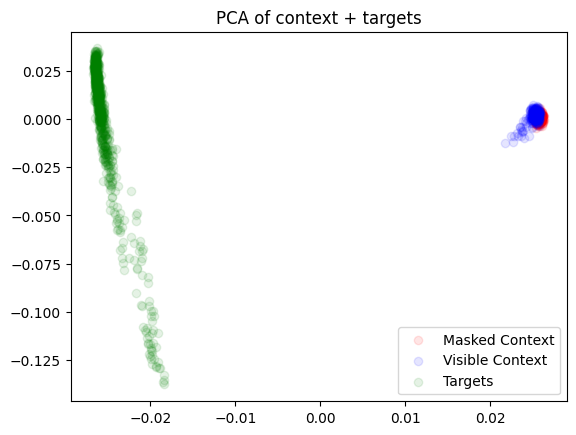

In [93]:
cat_vecs = torch.cat([res[0]['context_vectors'][0].cpu(), res[0]['targets'][0].cpu()], 0)
cat_vecs = cat_vecs / torch.norm(cat_vecs, dim=1, keepdim=True)

u, _, _ = torch.pca_lowrank(cat_vecs, q=2)
msk = res[0]['mask'][0]

cont_2d = u[:msk.shape[0], :]
tgt_2d = u[msk.shape[0]:, :]
plt.scatter(cont_2d[msk, 0], cont_2d[msk, 1], c='r', alpha=0.1, label='Masked Context')
plt.scatter(cont_2d[~msk, 0], cont_2d[~msk, 1], c='b', alpha=0.1, label='Visible Context')
plt.scatter(tgt_2d[:, 0], tgt_2d[:, 1], c='g', alpha=0.1, label='Targets')
plt.legend()
plt.title('PCA of context + targets')



Text(0, 0.5, 'Contexts')

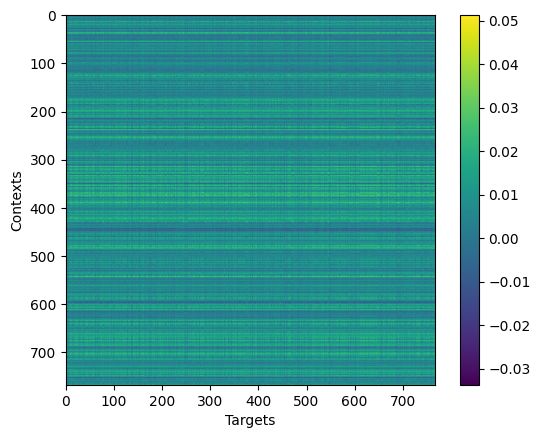

In [15]:
cont = res[0]['context_vectors'][1]
tgt = res[0]['targets'][1]

cont = cont / torch.norm(cont, dim=1, keepdim=True)
tgt = tgt / torch.norm(tgt, dim=1, keepdim=True)

# cont[300, :] = 10

sims = (cont @ tgt.T).detach().cpu()
plt.imshow(sims) # один контекст -- строчка. Для каких-то контекстов, все таргеты из подмножества идеально совпадают
plt.colorbar() # там где нет маски -- продолжается диагональ

plt.xlabel("Targets")  # Label for x-axis
plt.ylabel("Contexts")

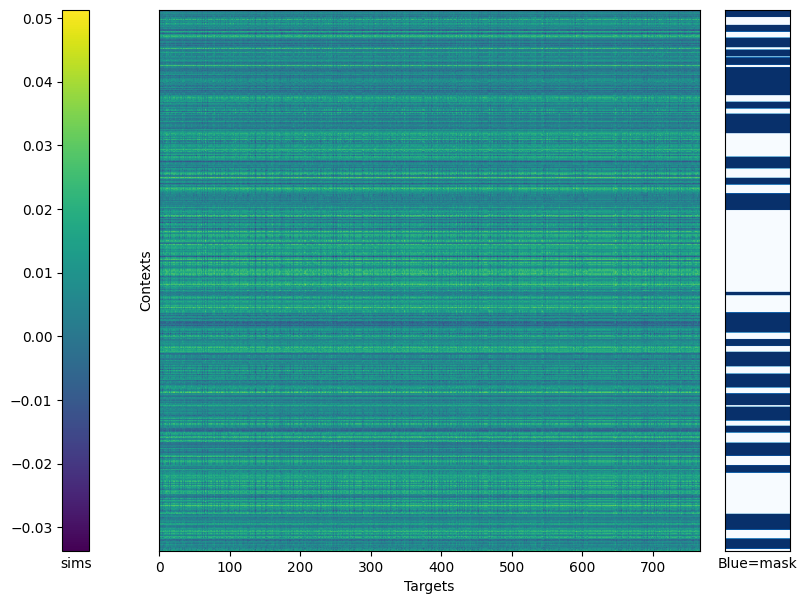

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming 'sims' is your similarity matrix and 'mask' is the boolean mask
mask = res[0]['mask'][1]

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 1]}, figsize=(8.2, 6), sharey=True)


divider = make_axes_locatable(ax[0])
cax = divider.append_axes("left", size="5%", pad=0.7)
cax.set_xlabel("sims")


im = ax[0].imshow(sims)
fig.colorbar(im, cax=cax)  # Place the colorbar on the left
cax.yaxis.set_ticks_position('left')  # Ensure the ticks are on the left
ax[0].set_xlabel("Targets")
ax[0].set_ylabel("Contexts")


mask_colors = np.where(mask, 1, 0)  # True becomes 1 (blue), False becomes 0 (white)


ax[1].imshow(mask_colors[:, None], cmap='Blues', aspect='auto')  # Single column mask
ax[1].set_xticks([])  
ax[1].set_yticks([])  
ax[1].set_xlabel("Blue=mask")

plt.tight_layout()
plt.show()


In [97]:
x = torch.rand(500, 100)

sim = x @ x.T

In [121]:
x = x / torch.norm(x, dim=1, keepdim=True)
q = torch.nn.functional.softmax(sim - torch.diagflat(torch.tile(torch.tensor(torch.inf), [500])), dim=1) 
(torch.log(q + 1e-5) * q).mean()

tensor([[0.0000, 0.0020, 0.0020,  ..., 0.0021, 0.0020, 0.0020],
        [0.0020, 0.0000, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0019, 0.0020, 0.0000,  ..., 0.0020, 0.0020, 0.0021],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0000, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0021,  ..., 0.0020, 0.0000, 0.0021],
        [0.0019, 0.0020, 0.0020,  ..., 0.0019, 0.0020, 0.0000]])

tensor(-0.0124)